## validating models against test dataset 1 (pre-declusters)

In [1]:
import pandas as pd

input_csv = "/Users/inesschwartz/Desktop/model/model_datasets/test_data.csv"
test_df = pd.read_csv(input_csv)

print(test_df.shape)
test_df.head()

(184, 53)


,log_soc_stock,DEM,MRRTF,MRVBF,TWI,X_coord,Y_coord,aspect,bio1,bio12,...,slope,slope_height,slope_length,standardized_height,terrain_surf_texture,terrain_surv_conv,tmax,total_curve,valley_depth,year
0,1.11,1477.82140,6.960664,8.731725,21.366892,589028.466030,8.656649e+06,3.976567,199.0,1268.0,...,0.006761,104.79858,855.36206,579.76710,58.423077,44.448780,26.845642,1.332990e-10,393.32556,1956.0
1,1.62,1201.55080,7.354778,8.700499,20.198360,945265.031883,8.838035e+06,2.677685,213.0,1352.0,...,0.014329,70.60196,320.81927,549.03900,67.006325,52.374790,27.500935,2.651238e-10,209.56810,1965.0
2,1.44,435.82562,4.116148,8.915597,24.163515,406734.521508,9.246797e+06,2.093850,242.0,949.0,...,0.010341,82.65298,10737.68300,164.72330,44.504020,48.280210,28.596115,1.972400e-10,657.34130,1959.0
3,2.07,1597.73490,6.973146,8.745792,23.793827,564265.548316,8.534381e+06,3.633138,190.0,1203.0,...,0.021065,110.13017,2083.10550,859.42270,60.393772,48.716830,25.723263,1.016203e-10,235.15665,1946.0
4,1.70,697.45070,3.153459,8.850451,20.343992,699269.488876,9.072847e+06,4.915011,238.0,1203.0,...,0.007255,93.91217,0.00000,230.60329,44.718365,44.274822,31.040636,1.172393e-10,597.87370,1963.0


In [2]:
rf_raster = "/Users/inesschwartz/Desktop/model/bagged_maps/RF_SOC_mean_MgCha.tif"

In [3]:
## rf raster
import rasterio
import geopandas as gpd
from shapely.geometry import Point
import numpy as np

# Convert test_df to GeoDataFrame
gdf_test = gpd.GeoDataFrame(
    test_df,
    geometry=gpd.points_from_xy(test_df.X_coord, test_df.Y_coord),
    crs="EPSG:32733"
)

# Open raster
with rasterio.open(rf_raster) as src:
    gdf_test["rf_pred"] = [
        val[0] if val[0] != src.nodata else np.nan
        for val in src.sample([(geom.x, geom.y) for geom in gdf_test.geometry])
    ]


In [4]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Back-transform test observations (ln → original units)
y_true = np.exp(gdf_test["log_soc_stock"].values)

# ## in log
# y_true = gdf_test["log_soc_stock"].values

# Predictions from back-transformed raster
y_pred = gdf_test["rf_pred"].values

# Compute metrics
mse = mean_squared_error(y_true, y_pred)
rmse = mse ** 0.5
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
bias = np.mean(y_pred - y_true)

print("🔍 Validation metrics against Test 1:")
print(f"R²   : {r2:.3f}")
print(f"RMSE : {rmse:.3f}")
print(f"MAE  : {mae:.3f}")
print(f"Bias : {bias:.3f}")


🔍 Validation metrics against Test 1:
R²   : 0.302
RMSE : 2.098
MAE  : 1.255
Bias : -0.237


In [5]:
print("y_true range:", np.nanmin(y_true), np.nanmax(y_true))
print("y_pred range:", np.nanmin(y_pred), np.nanmax(y_pred))
print("Mean y_true:", np.nanmean(y_true))
print("Mean y_pred:", np.nanmean(y_pred))


y_true range: 1.0 20.6972325893895
y_pred range: 1.3411311 8.443598
Mean y_true: 4.410617341464961
Mean y_pred: 4.1733623


The Random Forest SOC model demonstrated moderate predictive skill when evaluated against the independent Test 1 dataset. The model explained 30% of the variance (R² = 0.302), with an average prediction error of approximately 2.10 Mg C/ha (RMSE) and 1.26 Mg C/ha (MAE). The bias was small (–0.237 Mg C/ha), indicating minimal systematic over- or underestimation. These values are consistent with SOC mapping studies at national scale, where the inherent spatial heterogeneity of soil organic carbon typically leads to modest R² values and prediction errors in the range of 1–3 Mg C/ha.*

## compared against test1 test set and test2 (test set split for declusters and then averaged)

To evaluate the predictive performance of the soil organic carbon (SOC) models, we compared model predictions against two test sets: the original Test 1 dataset and the declustered test subsets. Validation against the full Test 1 set yielded an R² of 0.302, RMSE of 2.098 Mg C/ha, MAE of 1.255 Mg C/ha, and a slight negative bias of -0.237 Mg C/ha. These metrics reflect the model’s performance on the complete independent dataset, capturing the full spatial variability and extreme values present in the country-wide SOC observations. In contrast, performance metrics averaged across the declustered test subsets were notably better, with an R² of 0.372, RMSE of 0.409 Mg C/ha, MAE of 0.301 Mg C/ha, and negligible bias (0.002 Mg C/ha). The declustering process reduces spatial clustering and removes redundant or extreme observations, resulting in a more homogeneous sample and artificially lower prediction errors.

These differences highlight an important methodological point: while declustered averages are useful for comparing model performance and optimizing modeling choices (e.g., RF vs OK vs RF+OK), they do not fully capture the variability of the complete dataset. The Test 1 validation provides a more realistic assessment of model performance under real-world conditions, where extreme SOC values and spatial heterogeneity are present. Therefore, both sets of metrics are reported: declustered averages for internal model comparison and methodological evaluation, and Test 1 metrics for practical predictive accuracy.

In [17]:
## performance metrics:

import pandas as pd

# Define your Test 1 metrics (back-transformed / original SOC units)
metrics = {
    "Metric": ["R²", "RMSE (Mg C/ha)", "MAE (Mg C/ha)", "Bias (Mg C/ha)"],
    "Value": [0.302, 2.098, 1.255, -0.237]
}

metrics_df = pd.DataFrame(metrics)

# Print table
print("📊 Test 1 Validation Metrics")
print(metrics_df)

# Optional: save as CSV for thesis or supplementary
metrics_df.to_csv("/Users/inesschwartz/Desktop/model/results_cv_global/test1_metrics_table.csv", index=False)


📊 Test 1 Validation Metrics
           Metric  Value
0              R²  0.302
1  RMSE (Mg C/ha)  2.098
2   MAE (Mg C/ha)  1.255
3  Bias (Mg C/ha) -0.237


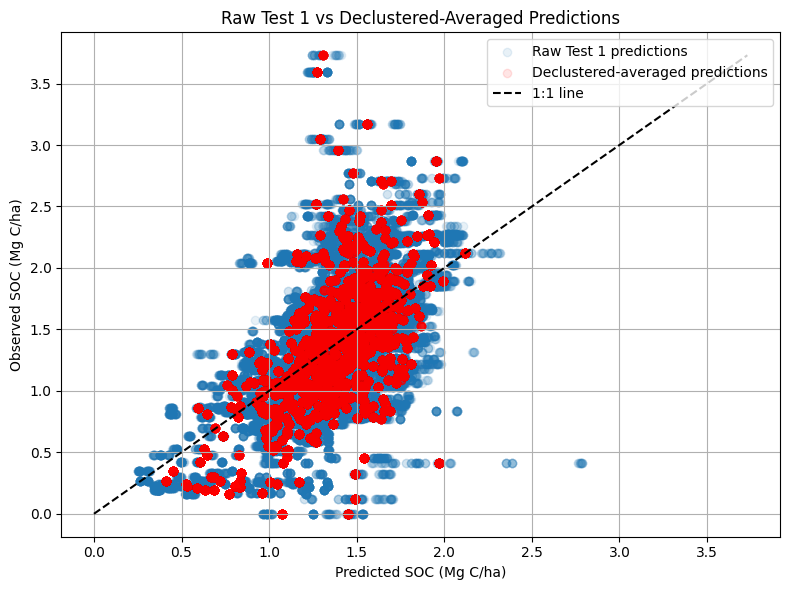

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load Test 1 predictions CSV (with original SOC units)
csv_path = "/Users/inesschwartz/Desktop/model/results_cv_global/cv_point_predictions_all_declusters.csv"
df = pd.read_csv(csv_path)

# If you have declustered-averaged predictions per site_info_id
# You can create a separate dataframe avg_df with columns: site_info_id, y_pred_avg
# For demonstration, let's assume you already have it:
# avg_df = pd.read_csv("/Users/inesschwartz/Desktop/model/results_cv_global/declustered_avg_predictions.csv")

# Merge raw Test 1 vs averaged predictions (assuming same site_info_id)
# merged_df = df[['site_info_id','y_true','y_pred']].merge(avg_df, on='site_info_id')

# For simplicity, let's use a mockup here using df grouped by site_info_id
avg_preds = df.groupby('site_info_id')['y_pred'].mean().reset_index()
merged_df = df[['site_info_id','y_true','y_pred']].drop_duplicates().merge(avg_preds, on='site_info_id')
merged_df.rename(columns={'y_pred_x':'raw_pred', 'y_pred_y':'avg_pred'}, inplace=True)

# Scatter plot
plt.figure(figsize=(8,6))
plt.scatter(merged_df['raw_pred'], merged_df['y_true'], alpha=0.1, label='Raw Test 1 predictions')
plt.scatter(merged_df['avg_pred'], merged_df['y_true'], alpha=0.1, color='red', label='Declustered-averaged predictions')
plt.plot([merged_df['y_true'].min(), merged_df['y_true'].max()],
         [merged_df['y_true'].min(), merged_df['y_true'].max()],
         color='black', linestyle='--', label='1:1 line')

plt.xlabel("Predicted SOC (Mg C/ha)")
plt.ylabel("Observed SOC (Mg C/ha)")
plt.title("Raw Test 1 vs Declustered-Averaged Predictions")
plt.legend()
plt.grid(True)
plt.tight_layout()

# Save figure
plt.savefig("/Users/inesschwartz/Desktop/model/results_cv_global/raw_vs_avg_predictions.png", dpi=400)
plt.show()


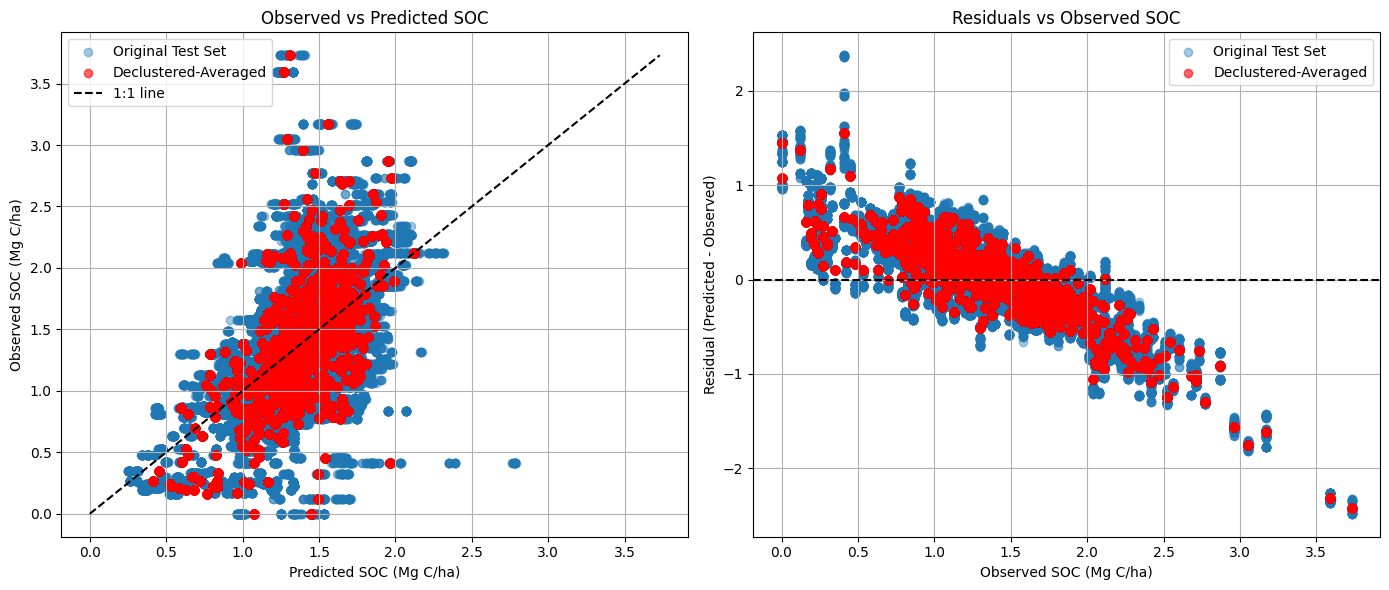

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# -----------------------------
# Load predictions CSV
# -----------------------------
csv_path = "/Users/inesschwartz/Desktop/model/results_cv_global/cv_point_predictions_all_declusters.csv"
df = pd.read_csv(csv_path)

# Compute declustered-averaged predictions per site
avg_preds = df.groupby('site_info_id')['y_pred'].mean().reset_index()
merged_df = df[['site_info_id','y_true','y_pred']].drop_duplicates().merge(avg_preds, on='site_info_id')
merged_df.rename(columns={'y_pred_x':'raw_pred', 'y_pred_y':'avg_pred'}, inplace=True)

# Compute residuals
merged_df['residual_raw'] = merged_df['raw_pred'] - merged_df['y_true']
merged_df['residual_avg'] = merged_df['avg_pred'] - merged_df['y_true']

# -----------------------------
# Plot scatter + residuals
# -----------------------------
fig, axes = plt.subplots(1, 2, figsize=(14,6))

# Scatter plot
axes[0].scatter(merged_df['raw_pred'], merged_df['y_true'], alpha=0.4, label='Original Test Set')
axes[0].scatter(merged_df['avg_pred'], merged_df['y_true'], alpha=0.6, color='red', label='Declustered-Averaged')
axes[0].plot([merged_df['y_true'].min(), merged_df['y_true'].max()],
             [merged_df['y_true'].min(), merged_df['y_true'].max()],
             color='black', linestyle='--', label='1:1 line')
axes[0].set_xlabel("Predicted SOC (Mg C/ha)")
axes[0].set_ylabel("Observed SOC (Mg C/ha)")
axes[0].set_title("Observed vs Predicted SOC")
axes[0].legend()
axes[0].grid(True)

# Residuals plot
axes[1].scatter(merged_df['y_true'], merged_df['residual_raw'], alpha=0.4, label='Original Test Set')
axes[1].scatter(merged_df['y_true'], merged_df['residual_avg'], alpha=0.6, color='red', label='Declustered-Averaged')
axes[1].axhline(0, color='black', linestyle='--')
axes[1].set_xlabel("Observed SOC (Mg C/ha)")
axes[1].set_ylabel("Residual (Predicted - Observed)")
axes[1].set_title("Residuals vs Observed SOC")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
# plt.savefig("/Users/inesschwartz/Desktop/model/results_cv_global/scatter_and_residuals.png", dpi=300)
plt.show()
